In [1]:
import sys
print(sys.path)

['/Users/maan/Documents/Office Projects/Prochip/napari-sim-processor/src', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages/IPython/extensions', '/Users/maan/.ipython']


In [2]:
import napari
from napari_sim_processor._sim_widget import reshape, SimAnalysis

pytorch found
fftw found using 8 threads


In [10]:
from IPython import get_ipython
get_ipython().config

{'IPKernelApp': {'connection_file': '/Users/maan/Library/Jupyter/runtime/kernel-3d3e5c92-b883-4c9c-996c-29aeadb8350e.json'}}

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Run the napari plugin and process a chosen dataset.  The calculations below are for a 140x128x128 dataset with 500 points.

In [4]:
viewer = napari.Viewer()
widget = SimAnalysis(viewer)
my_reshape_widget = reshape()
viewer.window.add_dock_widget(my_reshape_widget, name='Reshape stack', add_vertical_stretch=True)
viewer.window.add_dock_widget(widget,
                              name='Sim analyzer @Polimi',
                              add_vertical_stretch=True)
napari.run()

/usr/local/lib/python3.9/site-packages/superqt/qtcompat/__init__.py:7: UserWarning: The superqt.qtcompat module is deprecated as of v0.3.0. Please import from `qtpy` instead.
  warnings.warn(


Selected image layer: 128x128x140_x0_z50
Selected image layer: 128x128x140_x0_z50


# Post-processing the plugin processed data

If you perform a numpy batch process on the data-set it will save a copy of one of its intermediate images `img2` that is the internal calculated image after shifting and scaling bands to their new positions

In [5]:
img2 = widget.h.img2
widget.imageRaw_name

'128x128x140_x0_z50'

but actually the precursor to this is just an oversampled version of the input data that we will call `img1` here, and is simply calculated by dividing `img2` by the reconstruction factors

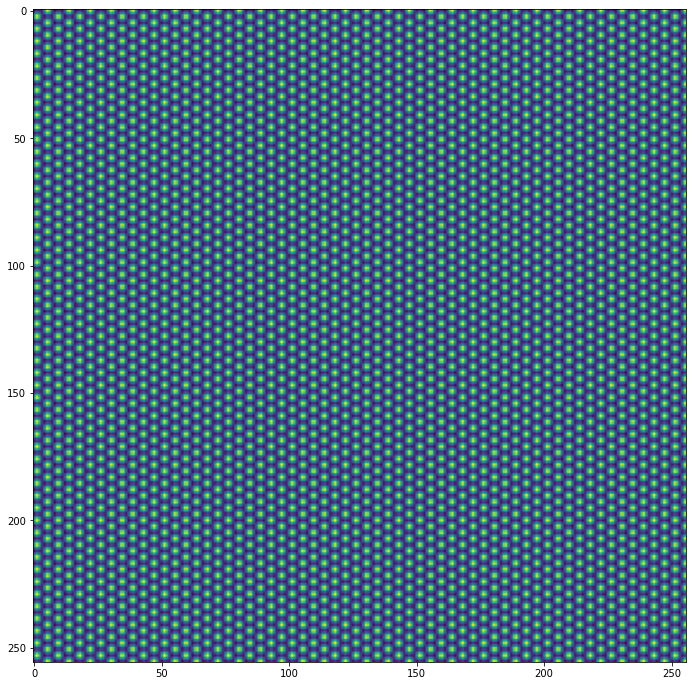

In [6]:
plt.figure(figsize=(12,12))
plt.imshow(widget.h._reconfactor[6, :, :])

In [7]:
img1 = np.zeros_like(img2)
for i in range(0, img1.shape[0], 7):
    img1[i:i+7, :, :] = img2[i:i+7, :, :] / widget.h._reconfactor

Here we display the summation of `img1` along the y-axis 

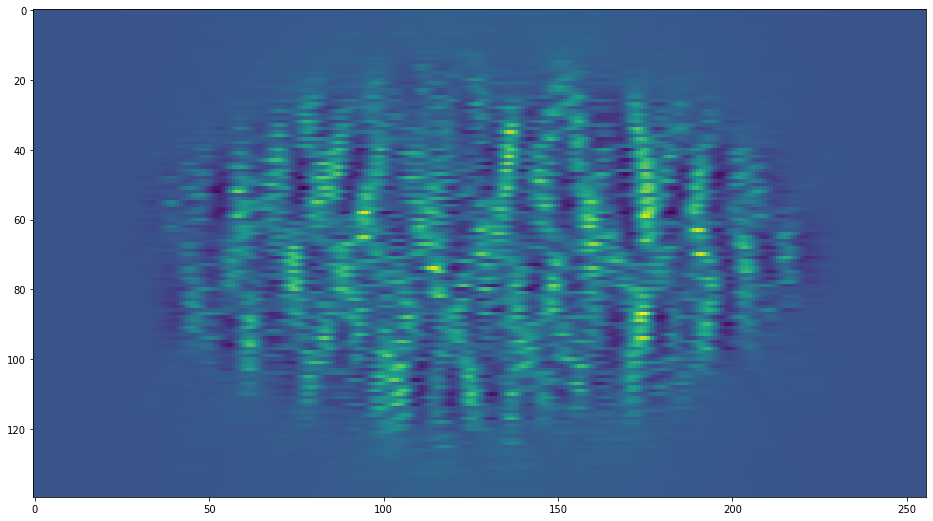

In [8]:
img1xz=np.sum(img1, 1)
plt.figure(figsize=(16,12))
plt.imshow(img1xz)

And calculate its Fourier transform to reveal lateral variation and the axial variation that is a combination of the slow drift in z and the 7 changing illumination patterns.

In [9]:
def log_p1(arr, offs=1000):
    return(np.log(arr + arr.max() / offs))

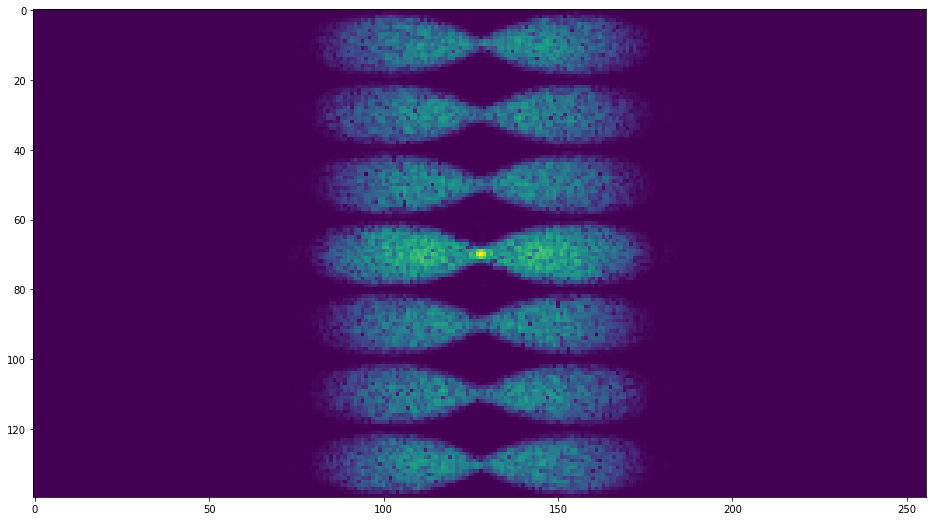

In [10]:
img1xzft = np.abs(np.fft.fftshift(np.fft.fft2(img1xz)))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(img1xzft))

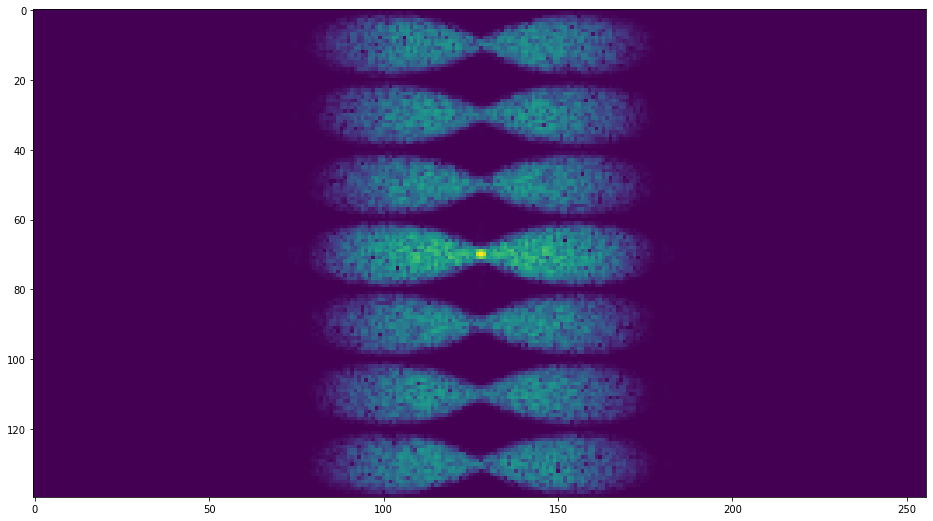

In [11]:
img1yzft = np.abs(np.fft.fftshift(np.fft.fft2(np.sum(img1, 2))))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(img1yzft))

Looking back at `img2` we can see that multiplying by the reconstruction factors has increased the information in the lateral direction (it has shifted the bands about, and has introduced significant structure in the z-direction. 

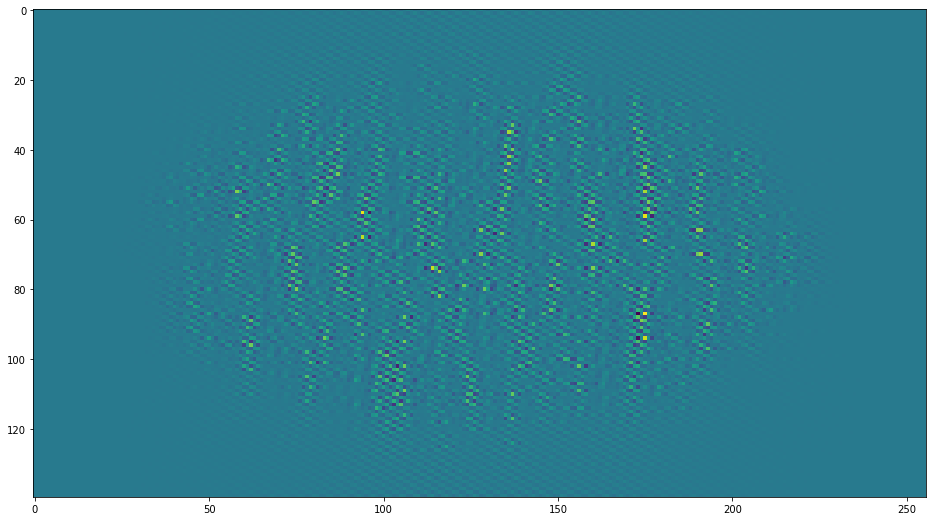

In [12]:
img2xz = np.sum(img2, 1)
plt.figure(figsize=(16,12))
plt.imshow(img2xz)#, vmin=img2xz.min()/4, vmax=img2xz.max()/4)

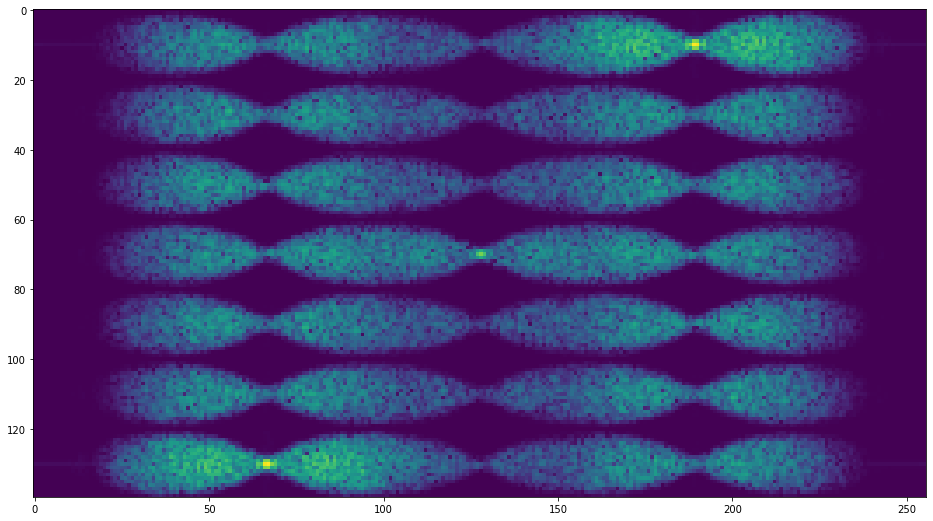

In [13]:
img2xzft = np.fft.fftshift(np.fft.fft2(img2xz))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(np.abs(img2xzft)))

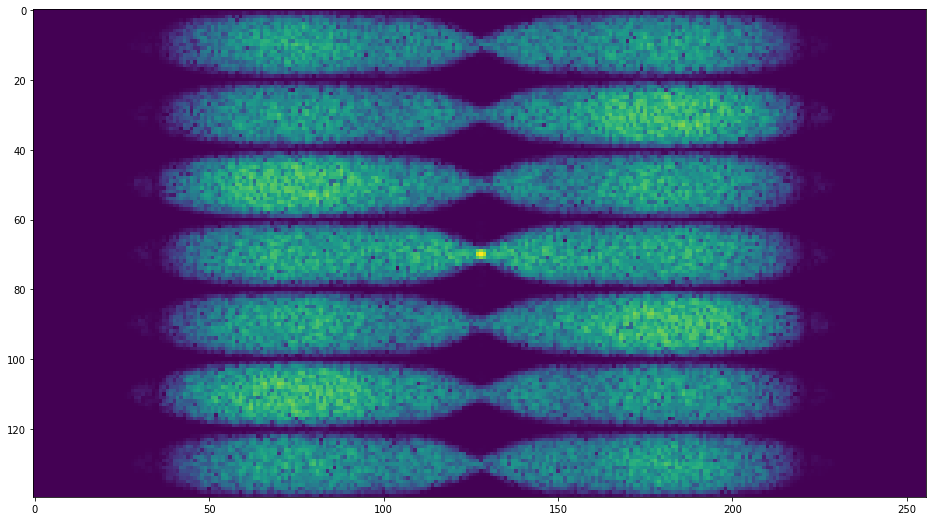

In [14]:
img2yzft = np.fft.fftshift(np.fft.fft2(np.sum(img2, 2)))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(np.abs(img2yzft)))

For rolling sim we take 7 images from `img2` at a time and add them up.  Note that we have a bit of an issue at the top/bottom of the stack as we run out of data.

In [15]:
r_sim = np.zeros_like(img2)
for i in range(3, r_sim.shape[0]-4):
    r_sim[i, :, :] = np.sum(img2[i-3:i+4, :, :], 0)

Again we can plot this as a summation in the y-direction and we still see high frequency artefacts.

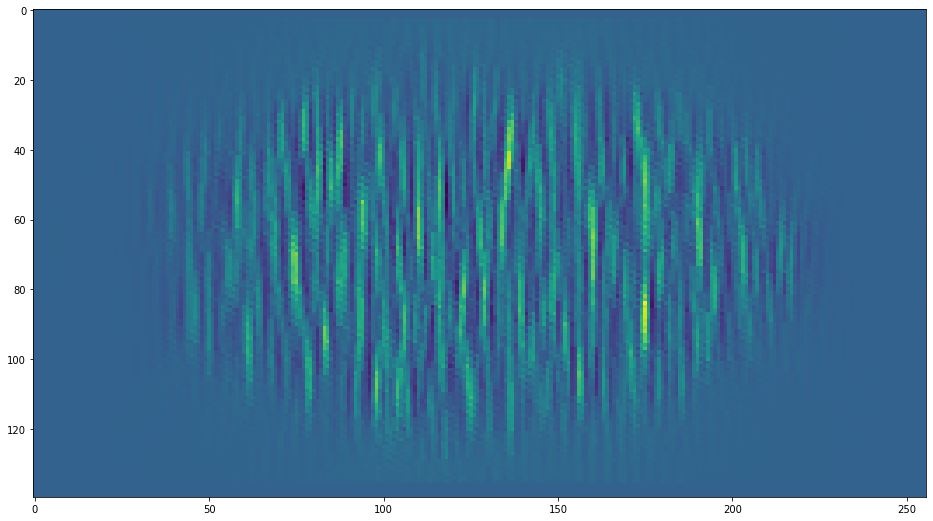

In [16]:
r_simxz = np.sum(r_sim, 1)
plt.figure(figsize=(16,12))
plt.imshow(r_simxz)

And show its Fourier spectrum in the xz plane.  Note here that the higher frequency components in `img2` have been suppressed (but not eliminated) by the filtering action of the summation in groups of 7. This will be equivalent to multimlyig by a `sinc` function in the z-direction which is revealed by the zeros in the Fourier spectrum 

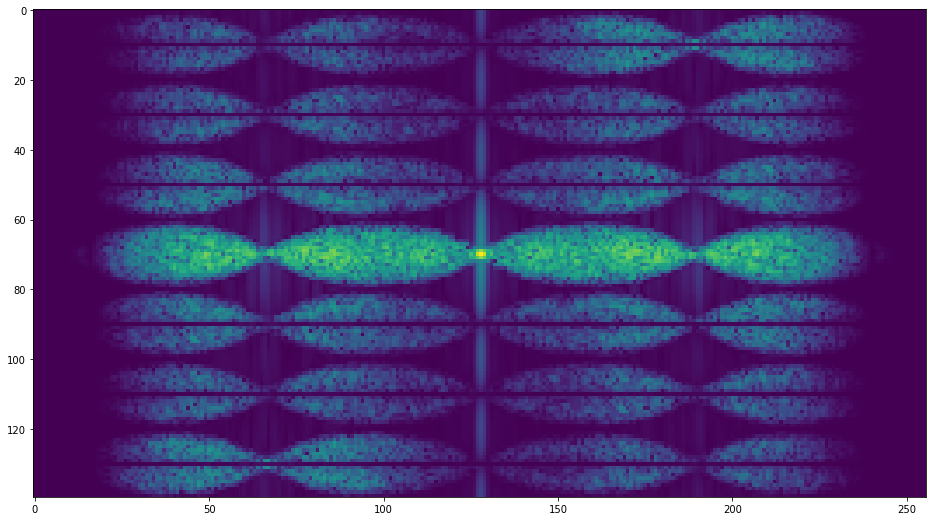

In [17]:
r_simxzft = np.abs(np.fft.fftshift(np.fft.fft2(r_simxz)))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(r_simxzft))

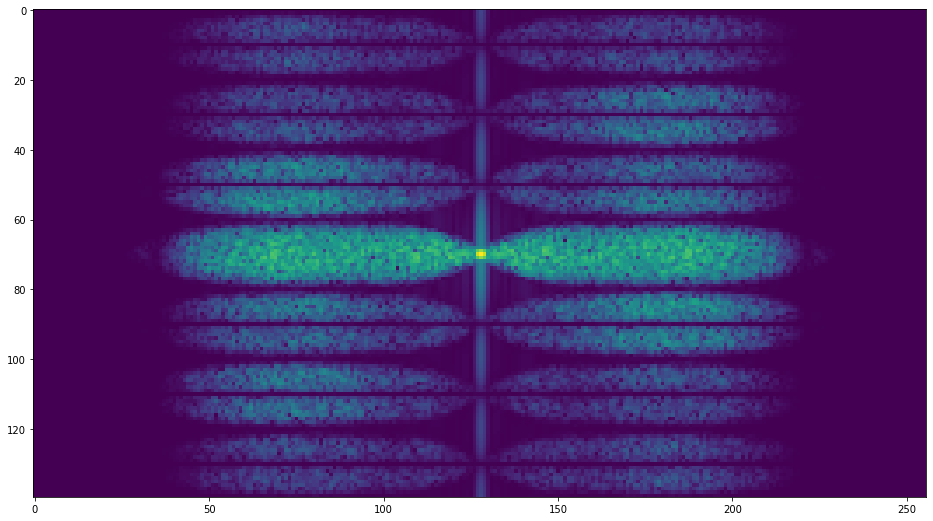

In [18]:
r_simyzft = np.abs(np.fft.fftshift(np.fft.fft2(np.sum(r_sim, 2))))
plt.figure(figsize=(16,12))
plt.imshow(log_p1(r_simyzft))

What this reveals is that it is not the higher spatial frequency components that are important, but rather only those in the 1/7 th of the spectral range around the zero order in the z-direction.  We can therefore perform a reconstruction by selecting just this zero-frequency band and nulling the higher bands to give us a final image `img4`. 

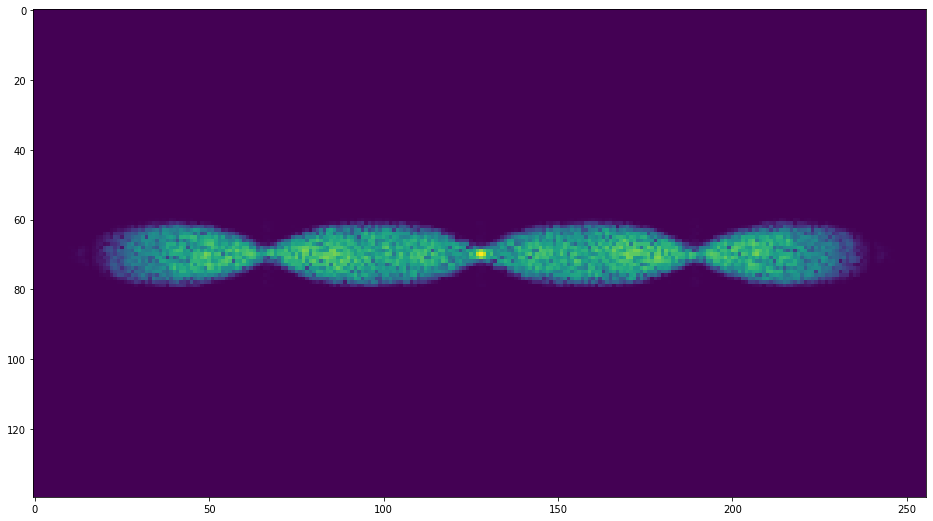

In [19]:
img4xzft = img2xzft.copy()
img4xzft[0:int(3 * r_sim.shape[0] / 7), :] = 0
img4xzft[int(4 * r_sim.shape[0] / 7)::, :] = 0

plt.figure(figsize=(16,12))
plt.imshow(log_p1(np.abs(img4xzft)))

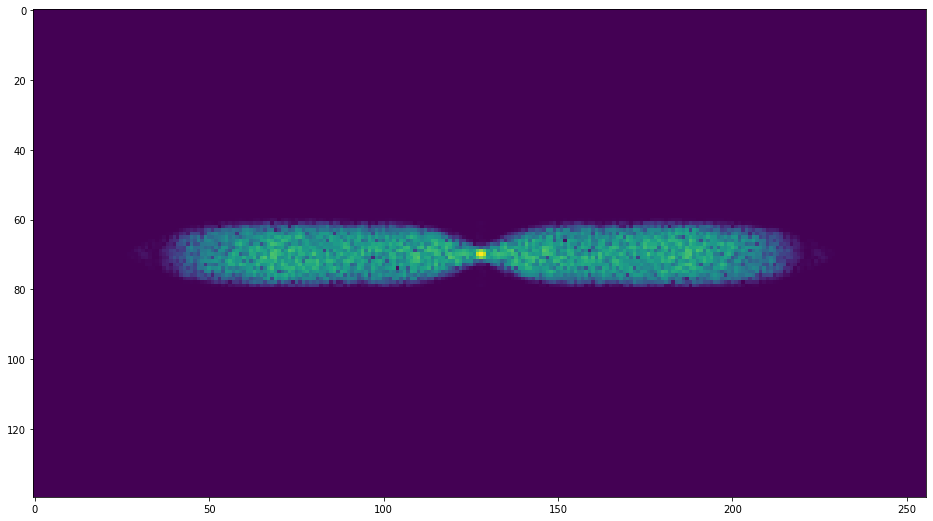

In [20]:
img4yzft = img2yzft.copy()
img4yzft[0:int(3 * r_sim.shape[0] / 7), :] = 0
img4yzft[int(4 * r_sim.shape[0] / 7)::, :] = 0

plt.figure(figsize=(16,12))
plt.imshow(log_p1(np.abs(img4yzft)))

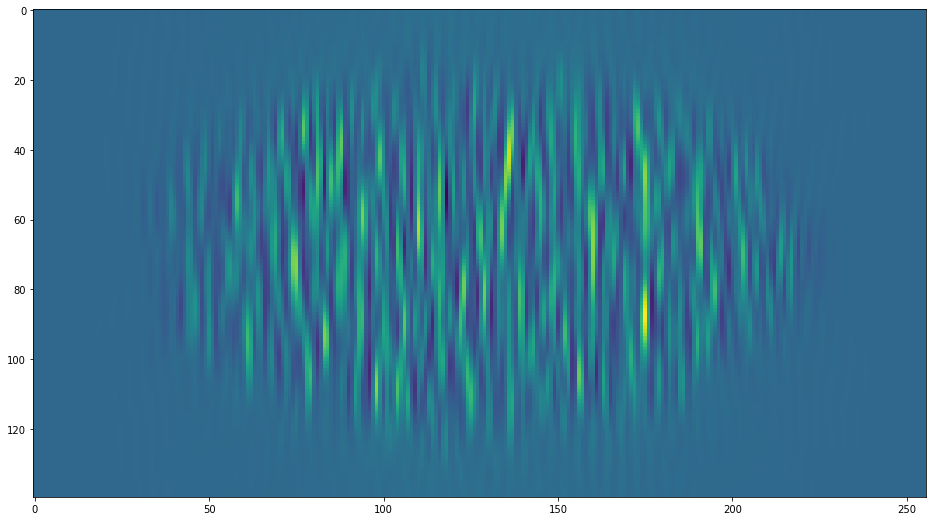

In [21]:
img4xz = np.fft.ifft2(np.fft.ifftshift(img4xzft))
plt.figure(figsize=(16,12))
plt.imshow(img4xz.real)

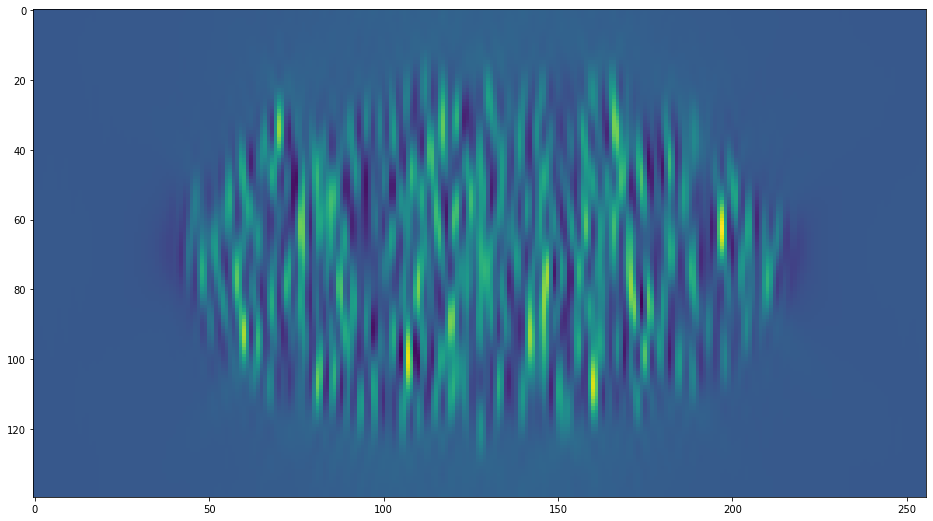

In [22]:
img4yz = np.fft.ifft2(np.fft.ifftshift(img4yzft))
plt.figure(figsize=(16,12))
plt.imshow(img4yz.real)

Note the lack of high frequency artefacts in the z-direction in `img4`.  This image is essentially what is calculated by the **batch process** commands in the `baseSimProcessor` classes.  The top hat filter in frequency space is equivalent to a sinc convolution in real space.  The actual code in the `baseSimProcessor` class, goes one step further and does not even bother with the nulled spatial frequencies in `img4` and by retaining just the zero-order band it generates an optimally sampled output dataset of just 40 slices from the input of 280. 

Or taking just single slices in the xz-direction we get

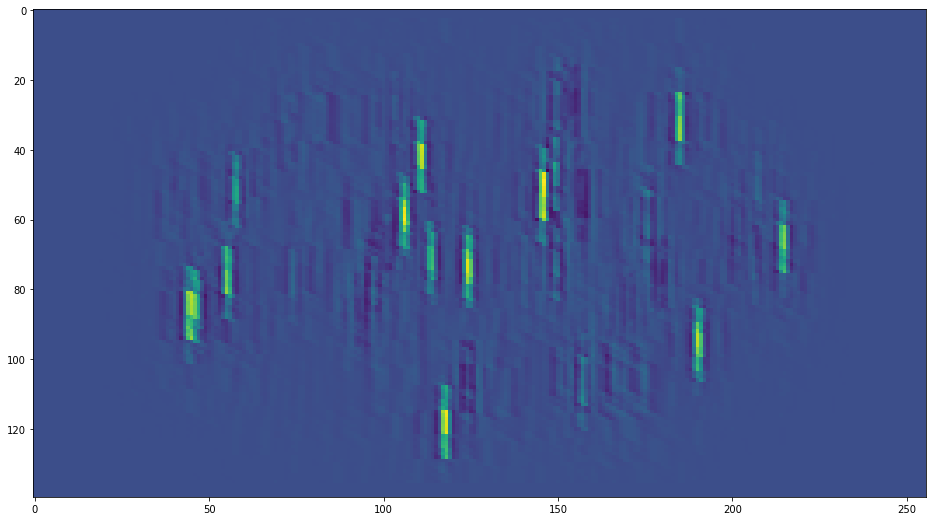

In [23]:
plt.figure(figsize=(16,12))
plt.imshow(r_sim[:, r_sim.shape[1] // 2, :])

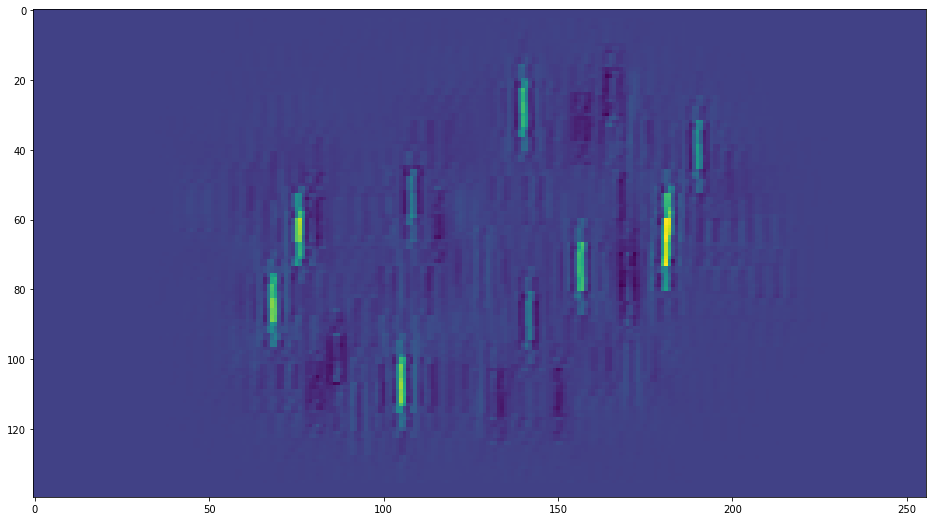

In [24]:
plt.figure(figsize=(16,12))
plt.imshow(r_sim[:, :, r_sim.shape[2] // 2])

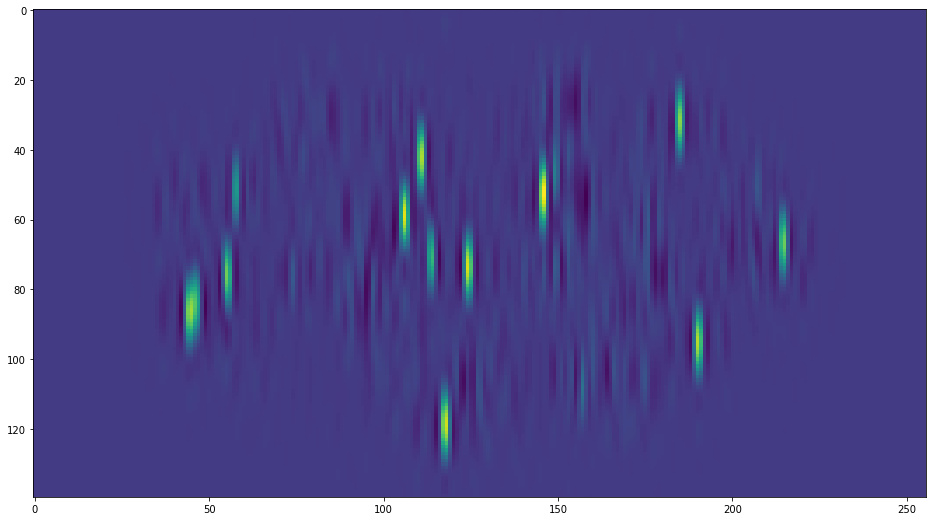

In [25]:
img2ft = np.fft.fft(img2, axis=0)
img2ft[img2.shape[0] // 14:-img2.shape[0] // 14, :, :] = 0
img4 = np.fft.ifft(img2ft, axis=0).real
plt.figure(figsize=(16,12))
plt.imshow(img4[:, img2.shape[1] // 2, :])

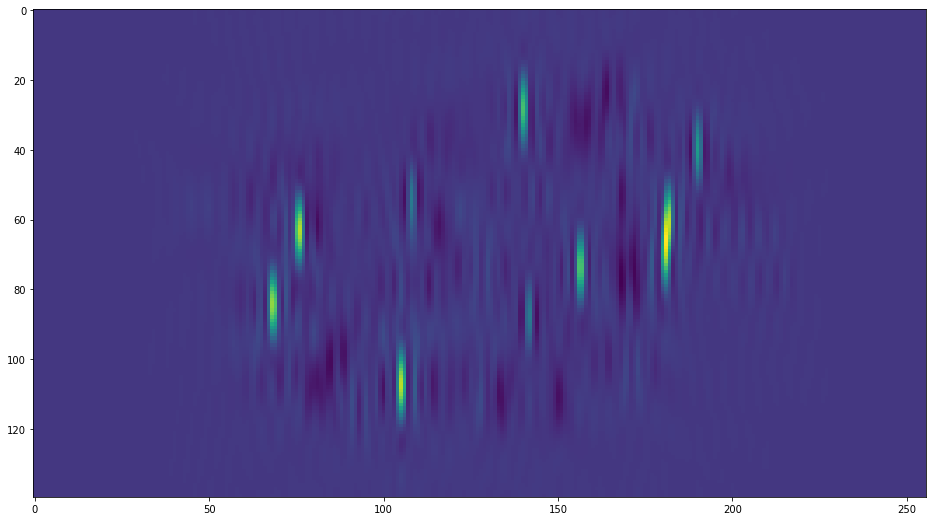

In [26]:
plt.figure(figsize=(16,12))
plt.imshow(img4[:, :, img2.shape[2] // 2])